# TO DO

1) Add another check for the collision since now we are introducing a robot and not more a rigid material point moving in the plane

2) In the steer function add the trajectory controller taking in account the dynamics of the robot and the fact that the robot is controlled in velocity

3) Decied how to do the feedback

# CODE

In [ ]:
#!pip install seaborn

In [1]:
import numpy as np
import math
from env import *
from plotting import *
import copy
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

## RRT + steer

In [2]:
class Node:
    def __init__(self, x, y):

        self.x = x
        self.xd = None
        self.xdd = None

        self.y = y
        self.yd = None
        self.ydd = None

        self.theta = None
        self.thetad = None
        self.thetadd = None

        self.parent = None
        self.cost = None

        self.commands = None
        self.conf = None


class RRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])

        ##################### INITIAL CONDITION #################
        self.node_s.theta = theta
        self.node_s.xd = xd
        self.node_s.xdd = xdd
        self.node_s.yd = yd
        self.node_s.ydd = ydd
        self.node_s.thetad = thetad
        self.node_s.thetadd = thetadd
        self.node_s.conf = [(self.node_s.x, self.node_s.y)]
        self.node_g.conf = [(self.node_g.x, self.node_g.y)]

        #########################################################

        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        # Empirical value
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//20
        self.trav_map = np.clip(np.random.normal(3, 8, size=(50, 30)), 2, 100)

    def planning(self):
        # ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        # plt.show()
        for iter in range(self.n_iters):
            if iter % 500 == 0:
                print(iter)
            # print(iter)
            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue
            
            ctr = Controller((n_nearest.x, n_nearest.y), (n_new.x, n_new.y))
            
            n_new_traj, xd, xdd, yd, ydd, thetaf, thetad, thetadd = ctr.steer(n_nearest.xd, n_nearest.xdd, n_nearest.yd, n_nearest.ydd, n_nearest.theta, n_nearest.thetad, n_nearest.thetadd)
            
            # if out_steer != False:
            #     n_new, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf = out_steer
            # else:
            #     continue
            n_new = Node(n_new_traj[-1][0], n_new_traj[-1][1])

            if not self.utils.is_collision(n_nearest, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):
                
                # Assign to node velocity, acceleration and commands
                n_new.xd = xd
                n_new.xdd = xdd
                n_new.yd = yd
                n_new.ydd = ydd
                n_new.theta = thetaf
                n_new.thetad = thetad
                n_new.thetadd = thetadd
                # n_new.commands = 0 #commands
                n_new.conf = n_new_traj

                N_near = self.compute_NN(n_new, near=True)
                n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)

        path = [[self.node_g]]
        goal_state = self.get_goal_state()

        self.tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, self.tot_path,
                                "rrt*, N = " + str(self.n_iters))

    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

        # print('LEN: ', len(N_near))
        for n_near in N_near:
            # print('before_steer')
            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue

            ctr = Controller((n_near.x, n_near.y), (n_new.x, n_new.y))
            n_new_traj, xd, xdd, yd, ydd, theta, thetad, thetadd = ctr.steer(n_near.xd, n_near.xdd, n_near.yd, n_near.ydd, n_near.theta, n_near.thetad, n_near.thetadd)
            # if out_steer != False:
            #     n_new_tr, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf = out_steer
            # else:
            #     continue
            # print('after_steer')
            n_new_tr = Node(n_new_traj[-1][0], n_new_traj[-1][0])

            if not self.utils.is_collision(n_near, n_new_tr) and int(n_new_tr.x) in range(0, self.env.x_range[-1]) and int(n_new_tr.y) in range(0, self.env.y_range[-1]):

                inter_cost = n_near.cost + \
                    self.compute_cost(n_near, n_new_tr)  # Intermediate cost
                if n_new_tr.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

                        n_new.xd = xd
                        n_new.xdd = xdd
                        n_new.yd = yd
                        n_new.ydd = ydd
                        n_new.theta = theta
                        n_new.thetad = thetad
                        n_new.thetadd = thetadd
                        # n_new.commands = commands
                        n_new.conf = n_new_traj

                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y
                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y

                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

                        n_new.xd = xd
                        n_new.xdd = xdd
                        n_new.yd = yd
                        n_new.ydd = ydd
                        n_new.theta = theta
                        n_new.thetad = thetad
                        n_new.thetadd = thetadd
                        # n_new.commands = commands
                        n_new.conf = n_new_traj

                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y
                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y
        # print('Sono uscito da Choose parent...')

        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):
        # print("LEN: ", len(N_near))
        for n_near in N_near:
            # print('kawabonga')
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue
            
            ctr = Controller((n_new.x, n_new.y), (n_near.x, n_near.y))
            n_new_traj, xd, xdd, yd, ydd, theta, thetad, thetadd = ctr.steer(n_new.xd, n_new.xdd, n_new.yd, n_new.ydd, n_new.theta, n_new.thetad, n_new.thetadd)
          
            # if out_steer != False:
            #     z_near, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf = out_steer
            # else:
            #     continue
            z_near = Node(n_new_traj[-1][0], n_new_traj[-1][1])

            if not self.utils.is_collision(z_near, n_new) and int(z_near.x) in range(0, self.env.x_range[-1]) and int(z_near.y) in range(0, self.env.y_range[-1]):

                if n_new.cost + self.compute_cost(z_near, n_new) < n_near.cost:

                    n_near_old_idx = self.Tree.index(n_near)
                    z_near.parent = n_new
                    z_near.cost = n_new.cost + self.compute_cost(z_near, n_new)
                    self.Tree[n_near_old_idx] = z_near

                    z_near.xd = xd
                    z_near.xdd = xdd
                    z_near.yd = yd
                    z_near.ydd = ydd
                    z_near.theta = theta
                    z_near.thetad = thetad
                    z_near.thetadd = thetadd
                    # z_near.commands = commands
                    z_near.conf = n_new_traj

        # print('sono uscito')
        return

    def compute_NN(self, n_curr, near=False):

        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta),
                         n_nearest.y + dist*math.sin(theta))

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            # print(x_new, y_new)
            return Node(x_new, y_new)

        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent
        path.append([n_curr])

        return path

    def compute_dist(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_cost(self, n1, n2):
        # Add Traversability!!!

        # Elevation on the real map
        n1_trav = self.trav_map[int(n1.x), int(n1.y)]
        n2_trav = self.trav_map[int(n2.x), int(n2.y)]

        increm = n2_trav - n1_trav  # Elevation between the two points
        plan_dist = self.compute_dist(n1, n2)  # Planar distance

        cost = math.sqrt(plan_dist**2 + increm**2)
        # cost = self.compute_dist(n1, n2)

        return cost

        
    

 

## RRT NO steer

In [ ]:
class Node:
    def __init__(self, x, y):

        self.x = x
        self.y = y
        self.parent = None
        self.cost = None


class RRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])

        #########################################################

        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        # Empirical value
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//15
        self.trav_map = np.clip(np.random.normal(3, 8, size=(50, 30)), 2, 100)

    def planning(self):
        # ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        # plt.show()
        print('TOT TIME TO EXECUTE IS {} seconds....'.format(tot_time))
        for iter in range(self.n_iters):
            if iter % 500 == 0:
                print(iter)
            # print(iter)
            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue

            if not self.utils.is_collision(n_nearest, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):
                # Assign to node velocity, acceleration and commands

                N_near = self.compute_NN(n_new, near=True)
                n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)
        path = [[self.node_g]]
        goal_state = self.get_goal_state()

        self.tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, self.tot_path,
                                "rrt*, N = " + str(self.n_iters), steer=False)

        self.c = Controller(self.tot_path, tot_time, start, goal)
        output = self.c.steer(xd, yd, xdd, ydd, theta, thetad, thetadd)

        self.plotting.animation(self.Tree, output[0],
                                "rrt*, N = " + str(self.n_iters), steer = False, real = True)
        return output[0]#, command

    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

        # print('LEN: ', len(N_near))
        for n_near in N_near:
            # print('before_steer')
            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue

            if not self.utils.is_collision(n_near, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):

                inter_cost = n_near.cost + \
                    self.compute_cost(n_near, n_new)  # Intermediate cost
                if n_new.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost


                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

        # print('Sono uscito da Choose parent...')

        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):
        # print("LEN: ", len(N_near))
        for n_near in N_near:
            # print('kawabonga')
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue


            if not self.utils.is_collision(n_near, n_new) and int(n_near.x) in range(0, self.env.x_range[-1]) and int(n_near.y) in range(0, self.env.y_range[-1]):

                if n_new.cost + self.compute_cost(n_near, n_new) < n_near.cost:

                    n_near_old_idx = self.Tree.index(n_near)
                    n_near.parent = n_new
                    n_near.cost = n_new.cost + self.compute_cost(n_near, n_new)
                    self.Tree[n_near_old_idx] = n_near

        # print('sono uscito')
        return

    def compute_NN(self, n_curr, near=False):

        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta),
                         n_nearest.y + dist*math.sin(theta))

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            # print(x_new, y_new)
            return Node(x_new, y_new)

        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent
        path.append([n_curr])

        return path

    def compute_dist(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_cost(self, n1, n2):
        # Add Traversability!!!

        # Elevation on the real map
        n1_trav = self.trav_map[int(n1.x), int(n1.y)]
        n2_trav = self.trav_map[int(n2.x), int(n2.y)]

        increm = n2_trav - n1_trav  # Elevation between the two points
        plan_dist = self.compute_dist(n1, n2)  # Planar distance

        cost = math.sqrt(plan_dist**2 + increm**2)
        # cost = self.compute_dist(n1, n2)

        return cost

## Controller

In [3]:
class Controller:

    def __init__(self, start, goal):
        
        self.T = math.sqrt((start[0]-goal[0])**2 + (start[1]-goal[1])**2)/(max_vel) + 1
        self.steps = np.arange(0, self.T, 1/freq)

        
        self.timing_law(start, goal)
        # self.x = self.pos(self.steps, 0)
        # self.y = self.pos(self.steps, 1)

        # self.xd = self.vel(self.steps, 0)
        # self.yd = self.vel(self.steps, 1)

        # self.xdd = self.acc(self.steps, 0)
        # self.ydd = self.acc(self.steps, 1)

        # self.xddd = self.jerk(self.steps, 0)*np.ones(self.x.shape)
        # self.yddd = self.jerk(self.steps, 1)*np.ones(self.y.shape)

        self.x = self.pos1(self.steps)
        self.y = self.pos2(self.steps)

        self.xd = self.vel1(self.steps)*np.ones(self.x.shape)
        self.yd = self.vel2(self.steps)

        self.xdd = self.acc1(self.steps)*np.ones(self.x.shape)
        self.ydd = self.acc2(self.steps)

        self.xddd = self.jerk1(self.steps)*np.ones(self.x.shape)
        self.yddd = self.jerk2(self.steps)*np.ones(self.y.shape)


        

        
        
    
   
    def timing_law(self, st, gl):
        ''' id => x : 0, y : 1 '''
        # self.pos = lambda t, id : st[id] + (t/self.T)**3*(gl[id] - st[id])
        # self.vel = lambda t, id : 3*(t**2)/(self.T**3)*(gl[id] - st[id])
        # self.acc = lambda t, id : 6*(t)/(self.T**3)*(gl[id] - st[id])
        # self.jerk = lambda t, id : 6/(self.T**3)*(gl[id] - st[id])

        self.pos1 = lambda t : st[0] + (t/self.T)*(gl[0]-st[0])
        self.pos2 = lambda t : st[1] + (1.0098*(t/self.T) - 0.0002*(t/self.T)**3 -0.0096*(t/self.T)**2)*(gl[1]-st[1])
        
        self.vel1 = lambda t : 1*(gl[0]-st[0])/(self.T)
        self.vel2 = lambda t : (-0.0006*t**2 - 0.0192*t + 1.0098)*(gl[1]-st[1])
        
        self.acc1 = lambda t : 0
        self.acc2 = lambda t : (-0.0012*t - 0.0192)*(gl[1]-st[1])

        self.jerk1 = lambda t : 0
        self.jerk2 = lambda t : -0.0012*(gl[1]-st[1])

        # self.pos1 = lambda t : t + start[0]
        # self.pos2 = lambda t : -0.002*t**3 + 0.1*t**2 + 0.1*t + start[1]
        
        # self.vel1 = lambda t : 1
        # self.vel2 = lambda t : -0.006*t**2 + 0.2*t + 0.1
        
        # self.acc1 = lambda t : 0
        # self.acc2 = lambda t : -0.012*t + 0.2

        # self.jerk1 = lambda t : 0
        # self.jerk2 = lambda t : -0.012





    

    def steer(self, xd, yd, xdd, ydd, theta, thetad, thetadd):

        # qd0 = np.array([[self.xd0*math.cos(self.theta0) - self.yd0*math.sin(self.theta0)],
        #                 [self.xd0*math.sin(self.theta0) + self.yd0*math.cos(self.theta0)],
        #                 [self.thetad0]])

        commands = []
        conf = []
        
        self.xd0 = xd
        self.yd0 = yd
        self.theta0 = theta
        self.thetad0 = thetad
        self.xdd0 = xdd 
        self.ydd0 = ydd  
        self.thetadd0 = thetadd 

        x = self.x[0]
        y = self.y[0]
        theta = self.theta0

        eta10 = xd = self.xd0
        eta20 = yd = self.yd0
        thetad = self.thetad0
        u10 = 0
        xdd = self.xdd0
        ydd = self.ydd0
        thetadd = self.thetadd0

        c = 0

        for state_idx in range(self.x.shape[0]):

            # The variable with the UNDERSCORE is the real one executed by the robot
            z1_, z2_, z1d_, z2d_, z1dd_, z2dd_ = self.compute_state(
                x, y, xd, yd, theta, xdd, ydd, thetad, thetadd)

            # print('real acc: ', z2dd_)
            # print('real pos: ', z2_)
            # print('real vel: ', z2d_)

            # print('des acc: ', self.ydd[state_idx])
            # print('des pos: ', self.y[state_idx])
            # print('des vel: ', self.yd[state_idx])
            # print('des jerk: ', self.yddd[state_idx])
            # print("Current position: ({}, {})\t Desired position ({}, {})".format(x, y, self.x[state_idx], self.y[state_idx]))
            # print('res acc X: ', self.xdd[state_idx] - z1dd_)
            # print('res acc Y: ', self.ydd[state_idx] - z2dd_)

            # print('res vel X: ', self.xd[state_idx] - z1d_)
            # print('res vel Y: ', self.yd[state_idx] - z2d_)

            # print('res pos X: ', self.x[state_idx] - z1_)
            # print('res vel Y: ', self.y[state_idx] - z2_)

            



            r1 = self.xddd[state_idx] + ka*(self.xdd[state_idx] - z1dd_) + kv * \
                (self.xd[state_idx] - z1d_) + kp*(self.x[state_idx] - z1_)
                
            r2 = self.yddd[state_idx] + ka*(self.ydd[state_idx] - z2dd_) + kv * \
                (self.yd[state_idx] - z2d_) + kp*(self.y[state_idx] - z2_)


            # print('R1: ', r1)
            # print('R2: ', r2)


            # Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)

            
            eps_d = math.cos(theta)*r1 + math.sin(theta) * \
                r2 + (1/(d0**2))*eta10*(eta20**2)
            
            # print('eps_d: ', eps_d)



            u1 = np.clip(eps_d*1/freq + u10, -12, 12)
            u10 = u1
            u2 = np.clip((d0/eta10)*(math.sin(theta)*r1 -
                        math.cos(theta)*r2)-(2/eta10)*u1*eta20, -12, 12)
            
            
            

            
            # print('u1/xdd: ', u1)
            # print('u2/ydd: ', u2)


            

            xf = x + (1/freq)*(math.cos(theta)*eta10 - math.sin(theta)*eta20)

            yf = y + (1/freq)*(math.sin(theta)*eta10 + math.cos(theta)*eta20) 

            thetaf = theta - (1/(d0*freq))*eta20

            eta1 = np.clip(u1*1/freq + eta10, -max_vel+0.3, max_vel-0.3)

            eta2 = np.clip(u2*1/freq + eta20, -max_vel+0.3, max_vel-0.3)

            thetad = -(eta2/d0)
            thetadd = -(u2/d0)


            # print('xf: ', xf)
            # print('yf: ', yf)
            # print('thetaf: ', thetaf)
            eta10 = eta1
            eta20 = eta2

            conf.append((xf, yf))

            xd = eta1
            yd = eta2

            # print('thetad: ', thetad)

            xdd = u1
            ydd = u2
            
            # print('thetadd: ', thetadd)
            # print('eta1/xd: ', eta1)
            # print('eta2/yd: ', eta2)
            



            theta = thetaf
            x = xf
            y = yf

        
        return conf, xd, xdd, yd, ydd, thetaf, thetad, thetadd

    def RK_integration(self, x, y, theta, T, v, w):
        ''' Runge Kutta integration for a generic differential drive robot'''
        xf = x+v*T*math.cos(theta*(w*T)/2)
        yf = y+v*T*math.sin(theta*(w*T)/2)
        thetaf = theta+w*T

        return xf, yf, thetaf

    def compute_friction(self, xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - t*thetad
        x3d = x2d = xd + t*thetad

        y1d = y2d = yd + a*thetad

        y3d = y4d = yd - b*thetad

        Rx = fr * (mass * g)/2 * (np.sign(x1d) + np.sign(x2d))

        Fy = mu * ((mass*g)/(a + b)) * \
            (b*np.sign(y1d) + a*np.sign(y3d))
        
        Mr = mu * ((a*b*mass*g)/(a + b))*(np.sign(y1d) -
                                          np.sign(y3d)) + fr*t*mass*g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr

    def compute_control(self, tau1, tau2, Rx, Fy, Mr, theta, qd0):
        '''This function computes the commands v and w useful for the Runge Kutta integration '''
        M = np.array([[mass, 0, 0], [0, mass, 0], [0, 0, Iz]])

        c = np.array([[Rx*math.cos(theta) - Fy*math.sin(theta)],
                     [Rx*math.sin(theta) + Fy*math.cos(theta)],
                      [Mr]])
        E = np.array([[math.cos(theta)/r, math.cos(theta)/r],
                      [math.sin(theta)/r, math.sin(theta)/r],
                      [t/r, -t/r]])
        tau = np.array([[tau1], [tau2]])

        R = np.array([[math.cos(theta), -math.sin(theta), 0],
                      [math.sin(theta), math.cos(theta), 0],
                      [0, 0, 1]])

        # print('E: ', E)
        # print('tau: ', tau)
        # print('c: ', c)



        qdd = np.linalg.inv(M)@(E@tau - c)

        # print("acc: ", qdd)

        qd = qdd*1/freq + qd0

        # print("vel: ", qd)


        vel = R.T@qd
        xd = vel[0]
        yd = vel[1]

        acc = R.T@qdd
        xdd = acc[0] + vel[1]*vel[2]
        ydd = acc[1] - vel[0]*vel[2]
        thetadd = qdd[2, 0]
        thetad = qd[2, 0]
        # print("xd: ", qd[0])
        # print("xdd: ", qdd[0])

        # print("yd: ", qd[1])
        # print("ydd: ", qdd[1])

        v = math.sqrt(qd[0]**2 + qd[1]**2)
        w = (qdd[1]*qd[0] - qdd[0]*qd[1]) / (qd[0]**2 + qd[1]**2)

        return float(v), float(w[0]), float(qd[0]), float(xd[0]), float(yd[0]), float(xdd[0]), float(ydd[0]), float(thetad), float(thetadd)

    def compute_state(self, x, y, xd, yd, theta, xdd, ydd, thetad, thetadd):
        
        z1_ = x + d0 * math.cos(theta)
        z2_ = y + d0 * math.sin(theta)

        z1d_ = xd*math.cos(theta) - yd*math.sin(theta) - \
                d0*math.sin(theta)*thetad
        z2d_ = xd*math.sin(theta) + yd*math.cos(theta) + \
                d0*math.cos(theta)*thetad

        z1dd_ = (xdd - yd*thetad)*math.cos(theta) - (ydd + xd*thetad)*math.sin(theta) - \
            d0*math.cos(theta)*(thetad**2) - d0*math.sin(theta)*thetadd

        z2dd_ = (xdd - yd*thetad)*math.sin(theta) + (ydd + xd*thetad)*math.sin(theta) - \
            d0*math.sin(theta)*(thetad**2) + d0*math.cos(theta)*thetadd 
        
        # z1dd_ = xdd*math.cos(theta) - yd*thetad*math.sin(theta) - d0 * \
        #         math.cos(theta)*thetad**2 - d0*math.sin(theta)*thetadd

        # z2dd_ = ydd*math.sin(theta) + xd*thetad*math.cos(theta) - d0 * \
        #         math.sin(theta)*thetad**2 + d0*math.cos(theta)*thetadd
      
        return z1_, z2_, z1d_, z2d_, z1dd_, z2dd_

## SIMULATION

In [4]:
env = Env(x_bounds=x_bounds, y_bounds=y_bounds)

rrt = RRT_STAR(start, goal, env, step, prob_gs, n_iters)

0
500


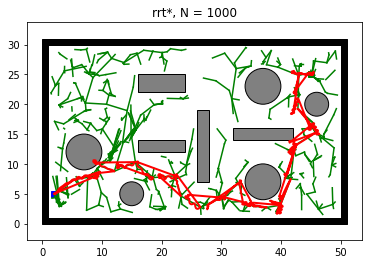

In [5]:
# conf, command = rrt.planning()
rrt.planning()

## Splines

In [ ]:
path = rrt.tot_path
len(path)

# Old planner

In [ ]:
class Controller:

    def __init__(self, path, T):
        
        path.reverse()

        x_coords = [node[0].x for node in path]
        y_coords = [node[0].y for node in path]
        self.n_nodes = len(path)
        discrete_steps = np.arange(0, len(path), 1)
        self.T = T #tot_time
        
        self.xd0 = xd
        self.yd0 = yd
        self.theta0 = theta
        self.thetad0 = thetad
        self.xdd0 = xdd 
        self.ydd0 = ydd  
        self.thetadd0 = thetadd  


        
        

        
        self.timing_law()

        spl_x = UnivariateSpline(discrete_steps, x_coords, k=5)
        spl_y = UnivariateSpline(discrete_steps, y_coords, k=5)

        self.steps = np.arange(0, self.T, 1/freq)

        self.x = spl_x(self.s(self.steps))
        self.y = spl_y(self.s(self.steps))

        self.xd = spl_x.derivative(n = 1)(self.s(self.steps))
        self.yd = spl_y.derivative(n = 1)(self.s(self.steps))
        
        # self.theta = np.arctan2(self.yd, self.xd)
     
        self.xdd = spl_x.derivative(n = 2)(self.s(self.steps))
        self.ydd = spl_y.derivative(n = 2)(self.s(self.steps))

        # self.thetad = (self.ydd*self.xd - self.xdd*self.yd) / (self.xd**2 + self.yd(self.s(self.steps))**2)


        self.xddd = spl_x.derivative(n = 3)(self.s(self.steps))
        self.yddd = spl_y.derivative(n = 3)(self.s(self.steps))
        
        
        self.ex_path = [path[0]]
    
   
    def timing_law(self):

        self.s = lambda t: (t/self.T)**3 * (self.n_nodes - 1)

    

    def steer(self):

        qd0 = np.array([[self.xd0*math.cos(self.theta0) - self.yd0*math.sin(self.theta0)],
                        [self.xd0*math.sin(self.theta0) + self.yd0*math.cos(self.theta0)],
                        [self.thetad0]])

        commands = []
        conf = []
        u10 = 0
        
        eta10 = 0
        eta20 = 0


        

        x = self.x[0]
        y = self.y[0]
        theta = self.theta0

        xd = self.xd0
        yd = self.yd0
        thetad = self.thetad0
        
        xdd = self.xdd0
        ydd = self.ydd0
        thetadd = self.thetadd0

        for state_idx in range(self.x.shape[0]):

            # The variable with the UNDERSCORE is the real one executed by the robot
            z1_, z2_, z1d_, z2d_, z1dd_, z2dd_ = self.compute_state(
                x, y, xd, yd, theta, xdd, ydd, thetad, thetadd)

            print('real acc: ', z1dd_)
            print('real pos: ', z1_)
            print('real vel: ', z1d_)

            print('des acc: ', self.xdd[state_idx])
            print('des pos: ', self.x[state_idx])
            print('des vel: ', self.xd[state_idx])
            print('des jerk: ', self.xddd[state_idx])



            r1 = self.xddd[state_idx] + ka*(self.xdd[state_idx] - z1dd_) + kv * \
                (self.xd[state_idx] - z1d_) + kp*(self.x[state_idx] - z1_)
            r2 = self.yddd[state_idx] + ka*(self.ydd[state_idx] - z2dd_) + kv * \
                (self.yd[state_idx] - z2d_) + kp*(self.y[state_idx] - z2_)


            print('R1: ', r1)
            print('R2: ', r2)


            Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)

            # print("Frictions: ", Rx, Fy, Mr)
            
            eps_d = math.cos(theta)*r1 + math.sin(theta) * \
                r2 + 1/d0*xd*yd**2
            
            print('eps_d: ', eps_d)



            u1 = eps_d*1/freq + u10
            u10 = u1
            # print("u1: ",u1)
            print('u1/xdd: ', u1)

            u2 = (d0/xd)*(math.sin(theta)*r1 -
                        math.cos(theta)*r2)-(2/xd)*u1*yd
            print('u2/ydd: ', u2)
            
            
            # print("u2: ",u2)
            
            # tau1 = r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) - ((r*d0) / (
            #     2*t)) * ((mass + (Iz/d0**2)) * u2 - (mass/d0)*xd*yd + Fy - Mr/d0)
            # tau2 = r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) + ((r*d0) / (
            #     2*t)) * ((mass + (Iz/d0**2)) * u2 - (mass/d0)*xd*yd + Fy - Mr/d0)

            #print('ERROR mass: ', mass * u1)#
            #print('Error mass2: ', mass/d0 * (yd**2))
            #print('ERROR Rx : ', Rx)
            #print("\n")
            
            #print('ERROR mass2: ', (r*d0) / (2*t)) 
            #print('Error mass3: ',  (mass + (Iz/d0**2)) )
            #print('Error mass4: ', u2 - mass/d0*xd*yd)
            #print('Error mass3 * mass 4: ',  (mass + (Iz/d0**2))* u2 - mass/d0*xd*yd)
            
            #print('ERROR Fy: ', Fy)
            #print("\n")

            #print('ERROR Mr/d0: ', Mr/d0)
            #print("\n") 
            # print('ERROR tau1: ', tau1)
            # print('ERROR tau2: ', tau2)
            # print("\n")


            # if tau1 > tau_max or tau1 < - tau_max:
            #     tau1 = np.sign(tau1)*tau_max
            # if tau2 > tau_max or tau2 < - tau_max:
            #     tau2 = np.sign(tau2)*tau_max

            #print('ERROR tau1: ', tau1)
            #print('ERROR tau2: ', tau2)

            # v, w, qdf, xd, yd, xdd, ydd, thetad, thetadd = self.compute_control(
            #     tau1, tau2, Rx, Fy, Mr, theta, qd0)
            # print('Acceleration ACC X: ', xdd)
            # print('Acceleration ACC Y: ', ydd)

            eta1 = u1*1/freq + eta10
            eta2 = u2*1/freq + eta20

            print('eta1/xd: ', eta1)
            print('eta2/yd: ', eta2)



            eta10 = eta1
            eta20 = eta2

            xf = x + (1/freq)*(math.cos(theta)*eta1 - math.sin(theta)*eta2)

            yf = y + (1/freq)*(math.sin(theta)*eta1 - math.cos(theta)*eta2) 

            thetaf = theta - (1/(d0*freq))*eta2


            print('xf: ', xf)
            print('yf: ', yf)
            print('thetaf: ', thetaf)


            # qd0 = qdf

            # commands.append((v, w))
            
            # print(theta, w)
            # xf, yf, thetaf = self.RK_integration(x, y, theta, 1/freq, v, w)
            conf.append((xf, yf))

            xd = eta1
            yd = eta2
            thetad = -(yd/d0)

            print('thetad: ', thetad)

            xdd = u1
            ydd = u2
            thetadd = -(ydd/d0)

            # print('XD: ', xd)
            # print('YD: ', yd)
            # print('THETAD: ', thetad)
            # print('XDD: ', xdd)
            # print('YDD: ', ydd)
            # print('THETADD: ', thetadd)



            theta = thetaf
            x = xf
            y = yf


        return conf, commands#n_new, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf

    def RK_integration(self, x, y, theta, T, v, w):
        ''' Runge Kutta integration for a generic differential drive robot'''
        xf = x+v*T*math.cos(theta*(w*T)/2)
        yf = y+v*T*math.sin(theta*(w*T)/2)
        thetaf = theta+w*T

        return xf, yf, thetaf

    def compute_friction(self, xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - t*thetad
        x3d = x2d = xd + t*thetad

        y1d = y2d = yd + a*thetad

        y3d = y4d = yd - b*thetad

        Rx = fr * (mass * g)/2 * (np.sign(x1d) + np.sign(x2d))

        Fy = mu * ((mass*g)/(a + b)) * \
            (b*np.sign(y1d) + a*np.sign(y3d))
        
        Mr = mu * ((a*b*mass*g)/(a + b))*(np.sign(y1d) -
                                          np.sign(y3d)) + fr*t*mass*g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr

    def compute_control(self, tau1, tau2, Rx, Fy, Mr, theta, qd0):
        '''This function computes the commands v and w useful for the Runge Kutta integration '''
        M = np.array([[mass, 0, 0], [0, mass, 0], [0, 0, Iz]])

        c = np.array([[Rx*math.cos(theta) - Fy*math.sin(theta)],
                     [Rx*math.sin(theta) + Fy*math.cos(theta)],
                      [Mr]])
        E = np.array([[math.cos(theta)/r, math.cos(theta)/r],
                      [math.sin(theta)/r, math.sin(theta)/r],
                      [t/r, -t/r]])
        tau = np.array([[tau1], [tau2]])

        R = np.array([[math.cos(theta), -math.sin(theta), 0],
                      [math.sin(theta), math.cos(theta), 0],
                      [0, 0, 1]])

        # print('E: ', E)
        # print('tau: ', tau)
        # print('c: ', c)



        qdd = np.linalg.inv(M)@(E@tau - c)

        # print("acc: ", qdd)

        qd = qdd*1/freq + qd0

        # print("vel: ", qd)


        vel = R.T@qd
        xd = vel[0]
        yd = vel[1]

        acc = R.T@qdd
        xdd = acc[0] + vel[1]*vel[2]
        ydd = acc[1] - vel[0]*vel[2]
        thetadd = qdd[2, 0]
        thetad = qd[2, 0]
        # print("xd: ", qd[0])
        # print("xdd: ", qdd[0])

        # print("yd: ", qd[1])
        # print("ydd: ", qdd[1])

        v = math.sqrt(qd[0]**2 + qd[1]**2)
        w = (qdd[1]*qd[0] - qdd[0]*qd[1]) / (qd[0]**2 + qd[1]**2)

        return float(v), float(w[0]), float(qd[0]), float(xd[0]), float(yd[0]), float(xdd[0]), float(ydd[0]), float(thetad), float(thetadd)

    def compute_state(self, x, y, xd, yd, theta, xdd, ydd, thetad, thetadd):
        
        z1_ = x + d0 * math.cos(theta)
        z2_ = y + d0 * math.sin(theta)

        z1d_ = xd*math.cos(theta) - yd*math.sin(theta) - \
                d0*math.sin(theta)*thetad
        z2d_ = xd*math.sin(theta) + yd*math.cos(theta) + \
                d0*math.cos(theta)*thetad

        z1dd_ = xdd*math.cos(theta) - yd*thetad*math.sin(theta) - d0 * \
                math.cos(theta)*thetad**2 - d0*math.sin(theta)*thetadd

        z2dd_ = ydd*math.sin(theta) + xd*thetad*math.cos(theta) - d0 * \
                math.sin(theta)*thetad**2 + d0*math.cos(theta)*thetadd
      
        return z1_, z2_, z1d_, z2d_, z1dd_, z2dd_